# First Neural Network 
## Predicting daily bike rental ridership

In [210]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

#### Load and prepare Data

In [2]:
data_path = "hour.csv"
rides = pd.read_csv(data_path)
rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


The dataset has number of riders for each hour of each day, that has been splitted into casual and registered.<br />
Let's see the no. of bike riders for the first 10 days. 


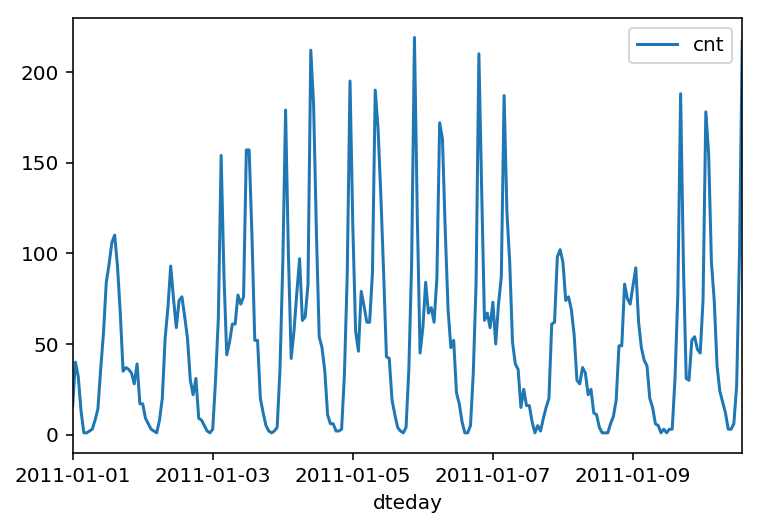

In [3]:
rides[:24*10].plot(x="dteday", y="cnt")

To include the categorical features, we'll make them binary dummy variables.

In [4]:
catg_variables = ["season","weathersit","mnth","hr","weekday"]

for var in catg_variables:
    dummy = pd.get_dummies(rides[var], prefix = var, drop_first=False)
    rides = pd.concat([rides, dummy], axis = 1)
    
features_to_drop = ["instant","dteday","season","weathersit","mnth","hr","weekday","atemp","workingday"]
data = rides.drop(features_to_drop, axis=1)
data.head()
    

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


Let's scale some variables to zero mean and standard deviation as 1 

In [5]:
scale_features = ["casual","registered","cnt","temp","hum","windspeed"]
scaled_features = {}

for var in scale_features:
    mean, std = data[var].mean(), data[var].std()
    scaled_features[var] = [mean,std]
    data.loc[:,var] = (data[var]-mean)/std
    

#### Splitting the data into training, testing and validation sets 

In [6]:
#test data of last 21 days
test_data = data[-21*24:]
#remove the testdata
data = data[:-21*24]
#seperate into features and target
target_fields = ["casual","registered","cnt"]

features,target = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_target = test_data.drop(target_fields, axis=1), test_data[target_fields]

Let's have last 60 days of training data as validation set

In [7]:
train_features, train_target = features[:-60*24], target[:-60*24]
val_features, val_target = features[-60*24:], target[-60*24:]

#### Build a Neural Network

- The network has two layers, one hidden and one output.
- Hidden layer uses sigmoid function as activation function.
- The output layer has only one node and is used for the regression, the output of the node is the same as the input of the node.

In [235]:
class NeuralNetwork(object):
    
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes
        
        #initialize the weights
        self.weights_input_to_hidden = np.random.normal(0.0, self.input_nodes**-0.5,
                                                       (self.input_nodes, self.hidden_nodes))
        self.weights_hidden_to_output = np.random.normal(0.0, self.hidden_nodes**-0.5,
                                                        (self.hidden_nodes, self.output_nodes))
        self.lr = learning_rate
        
        #activation function
        self.activation_function = lambda x: 1/(1 + np.exp(-x))
        #self.activation_function = lambda x: np.tanh(x)
        
        
    def train(self, features, target):
        #train the network on batch of features and targets
        
        n_records = features.shape[0]
        delta_weights_i_h = np.zeros(self.weights_input_to_hidden.shape)
        delta_weights_h_o = np.zeros(self.weights_hidden_to_output.shape)
        
        for X,y in zip(features, target):
            #Forward pass
            #To hidden layer
            #print(X, self.weights_input_to_hidden)
            #print(X.shape, self.weights_input_to_hidden.shape)
            hidden_inputs = np.dot(X, self.weights_input_to_hidden)
            hidden_outputs = self.activation_function(hidden_inputs)
            
            #To output layer
            #print(hidden_outputs, self.weights_hidden_to_output)
            #print(hidden_outputs.shape, self.weights_hidden_to_output.shape)
            final_input = np.dot(hidden_outputs, self.weights_hidden_to_output)
            final_output = final_input
            
            #print("final output = {0}".format(final_output))
            
            #Backward Pass
            #Output Error
            #print(y,final_output)
            output_error = y - final_output
            #print(output_error)
            
            #Backpropagated error terms
            output_error_grad = output_error * (final_output) * (1- final_output)
            #print("output_error_grad = {0}".format(output_error_grad))
            
            
            #back to Hidden error
            #print(output_error_grad, self.weights_hidden_to_output)
            hidden_error = output_error_grad * self.weights_hidden_to_output
            #print("hidden error = {0}".format(hidden_error))
            
            
            #Backpropagated error terms
            #print(hidden_outputs,1-hidden_outputs)
            hidden_error_grad = np.dot(hidden_error,np.dot(hidden_outputs,(1-hidden_outputs)))
            #print("hidden error_grad  = {0}".format(hidden_error_grad))
            
            
            # Weight step (input to hidden)
            #print(hidden_error_grad, X)
            delta_weights_i_h += np.dot(hidden_error_grad,X[None,:]).T
            #print("X[:,None] shape = {0}".format(X[:,None].shape))
            #print("delta_weights_i_h = {0}".format(delta_weights_i_h))
            
            
            # Weight step (hidden to output)
            #print(delta_weights_h_o.shape, output_error_grad.shape, hidden_outputs[:,None].shape)
            #print("delta_weights_h_o shape = {0}".format(delta_weights_h_o.shape))
            #print(hidden_outputs[:,None],output_error_grad)
            #print(output_error_grad*hidden_outputs[:,None])
            #print(delta_weights_h_o)
            delta_weights_h_o += output_error_grad*hidden_outputs[:,None]
            #print(delta_weights_h_o)
            
        #Update the weights
        self.weights_hidden_to_output += (self.lr*delta_weights_h_o)/float(n_records)
        #print(self.weights_hidden_to_output)
        self.weights_input_to_hidden += (self.lr*delta_weights_i_h)/float(n_records)
        #print(self.weights_input_to_hidden)
        
        
    def run(self, features):
        #Forward pass
        #To hidden layer
        hidden_inputs = np.dot(features, self.weights_input_to_hidden)
        hidden_outputs = self.activation_function(hidden_inputs)

        #To output layer
        #print(hidden_outputs.shape, self.weights_hidden_to_output.shape)
        final_input = np.dot(hidden_outputs, self.weights_hidden_to_output)
        final_output = final_input
        
        return final_output          
       

In [236]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

In [237]:
import unittest

inputs = np.array([[0.5, -0.2, 0.1]])
targets = np.array([[0.4]])
test_w_i_h = np.array([[0.1, -0.2],
                       [0.4, 0.5],
                       [-0.3, 0.2]])
test_w_h_o = np.array([[0.3],
                       [-0.1]])

class TestMethods(unittest.TestCase):
    
    ##########
    # Unit tests for data loading
    ##########
    
    def test_data_path(self):
        # Test that file path to dataset has been unaltered
        #print("file check")
        self.assertTrue(data_path.lower() == 'hour.csv')
        
    def test_data_loaded(self):
        # Test that data frame loaded
        #print("Is dataframe")
        self.assertTrue(isinstance(rides, pd.DataFrame))
    
    ##########
    # Unit tests for network functionality
    ##########

    def test_activation(self):
        network = NeuralNetwork(3, 2, 1, 0.5)
        # Test that the activation function is a sigmoid
        #print("Activation Function")
        #print(network.activation_function(0.5),1/(1+np.exp(-0.5)))
        #self.assertTrue(np.all(network.activation_function(0.5) == 1/(1+np.exp(-0.5))))

    def test_train(self):
        # Test that weights are updated correctly on training
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()
        
        network.train(inputs, targets)
        #print("H-O")
        #print(network.weights_hidden_to_output)
        #print("I-H")
        #print(network.weights_input_to_hidden)
        #self.assertTrue(np.allclose(network.weights_hidden_to_output, 
        #                            np.array([[ 0.30654717],
        #                                      [-0.09385623]])))
        #
        #self.assertTrue(np.allclose(network.weights_input_to_hidden,
        #                            np.array([[ 0.10100791,-0.20033597],
        #                                      [ 0.39959684,0.50013439],
        #                                      [-0.29979842,0.19993281]])))

    def test_run(self):
        # Test correctness of run method
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()
        
        #print("Final Output")
        #print(network.run(inputs))
        #self.assertTrue(np.allclose(network.run(inputs), 0.09998924))

suite = unittest.TestLoader().loadTestsFromModule(TestMethods())
unittest.TextTestRunner().run(suite)

.....
----------------------------------------------------------------------
Ran 5 tests in 0.007s

OK


<unittest.runner.TextTestResult run=5 errors=0 failures=0>

#### Training the Network

In [238]:
import sys

#set the hyperparameters
iterations = 1500
learning_rate = 0.008
hidden_nodes = 13
output_nodes = 1


N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for ii in range(iterations):
    # Go through a random batch of 128 records from the training data set
    batch = np.random.choice(train_features.index, size=128)
    X, y = train_features.ix[batch].values, train_target.iloc[batch]['cnt']
                             
    network.train(X, y)
    
    # Printing out the training progress
    train_loss = MSE(network.run(train_features).T, train_target['cnt'].values)
    val_loss = MSE(network.run(val_features).T, val_target['cnt'].values)
    sys.stdout.write("\rProgress: {:2.1f}".format(100 * ii/float(iterations)) \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    sys.stdout.flush()
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)



Progress: 99.9% ... Training loss: 0.822 ... Validation loss: 1.119

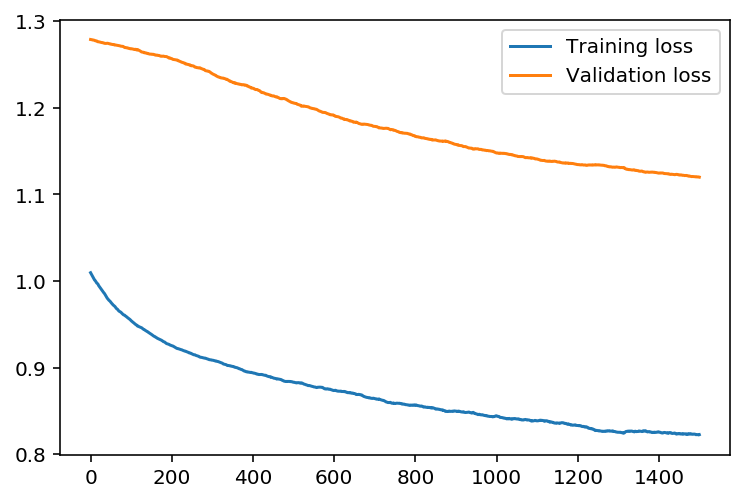

In [239]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
_ = plt.ylim()

#### Check out predictions

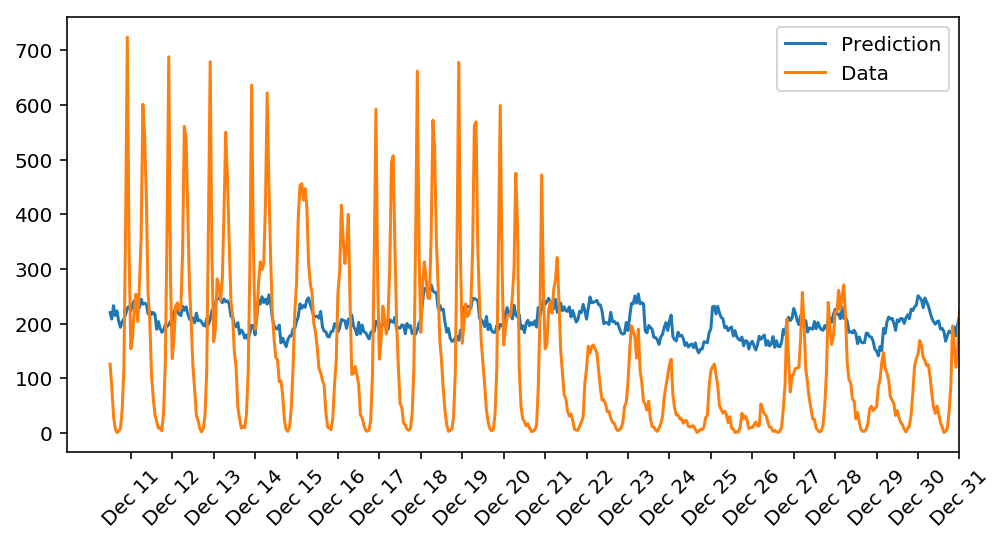

In [241]:
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['cnt']
predictions = network.run(test_features).T*std + mean
ax.plot(predictions[0], label='Prediction')
ax.plot((test_target['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.iloc[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)